In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# Sklearn Kütüphaneleri
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [ ]:
# 1. VERİLERİ YÜKLEME

print("--- VERİLER YÜKLENİYOR ---")
try:
    X_train = pd.read_csv('/content/drive/MyDrive/diabet_erken_teshis/X_train.csv')
    y_train = pd.read_csv('/content/drive/MyDrive/diabet_erken_teshis/y_train.csv').values.ravel()
    X_test = pd.read_csv('/content/drive/MyDrive/diabet_erken_teshis/X_test.csv')
    y_test = pd.read_csv('/content/drive/MyDrive/diabet_erken_teshis/y_test.csv').values.ravel()
    print(f"Veri Hazır: {X_train.shape}")
except FileNotFoundError:
    print("HATA: csv dosyaları bulunamadı. Lütfen önceki adımları çalıştırın.")

--- VERİLER YÜKLENİYOR ---
Veri Hazır: (81410, 132)


In [ ]:
# Sonuçları Kaydetmek İçin Tablo
results_df = pd.DataFrame(columns=['Aşama', 'Model', 'Parametreler', 'Accuracy', 'Recall', 'F1 Score'])

def add_result(stage, model_name, params, y_true, y_pred):
    global results_df
    new_row = {
        'Aşama': stage,
        'Model': model_name,
        'Parametreler': params,
        'Accuracy': round(accuracy_score(y_true, y_pred), 4),
        'Recall': round(recall_score(y_true, y_pred), 4),
        'F1 Score': round(f1_score(y_true, y_pred), 4)
    }
    results_df.loc[len(results_df)] = new_row

    print(f"\n {stage} SONUCU ({model_name})")
    print(f"    Parametreler: {params}")
    print(f"   Accuracy: {new_row['Accuracy']}  |  Recall: {new_row['Recall']}  |  ⭐ F1 Score: {new_row['F1 Score']}")
    print("-" * 60)


Değerlendirme motoru ve run_experiment fonksiyonu tanımlandı. Deneyler diğer hücrelerde çalıştırılacaktır.


In [ ]:
def plot_side_by_side_cm(y_test, pred1, name1, pred2, name2, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # CM 1
    sns.heatmap(confusion_matrix(y_test, pred1), annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title(f"{name1}\nRecall: {recall_score(y_test, pred1):.2f}")
    axes[0].set_xlabel("Tahmin")
    axes[0].set_ylabel("Gerçek")

    # CM 2
    sns.heatmap(confusion_matrix(y_test, pred2), annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axes[1])
    axes[1].set_title(f"{name2}\nRecall: {recall_score(y_test, pred2):.2f}")
    axes[1].set_xlabel("Tahmin")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# ADIM 1: BASELINE MODELLER (HAM VERİ)

print("\n--- ADIM 1: BASELINE MODELLER ÇALIŞIYOR (TÜM SÜTUNLAR) ---")

# A. MultinomialNB Baseline (MinMaxScaler Şart)
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

mnb_base = MultinomialNB() # Hiçbir ayar yok, dümdüz
mnb_base.fit(X_train_mm, y_train)
y_pred_mnb_base = mnb_base.predict(X_test_mm)
add_result('1. Baseline', 'MultinomialNB', 'Default', y_test, y_pred_mnb_base)


--- ADIM 1: BASELINE MODELLER ÇALIŞIYOR (TÜM SÜTUNLAR) ---

 1. Baseline SONUCU (MultinomialNB)
    Parametreler: Default
   Accuracy: 0.8882  |  Recall: 0.0  |  F1 Score: 0.0
------------------------------------------------------------


In [ ]:
# B. Decision Tree Baseline (StandardScaler İyidir)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

dt_base = DecisionTreeClassifier(random_state=42) # Hiçbir ayar yok, sınırsız derinlik
dt_base.fit(X_train_std, y_train)
y_pred_dt_base = dt_base.predict(X_test_std)
add_result('1. Baseline', 'DecisionTree', 'Default', y_test, y_pred_dt_base)



 1. Baseline SONUCU (DecisionTree)
    Parametreler: Default
   Accuracy: 0.8017  |  Recall: 0.1783  |  F1 Score: 0.1671
------------------------------------------------------------


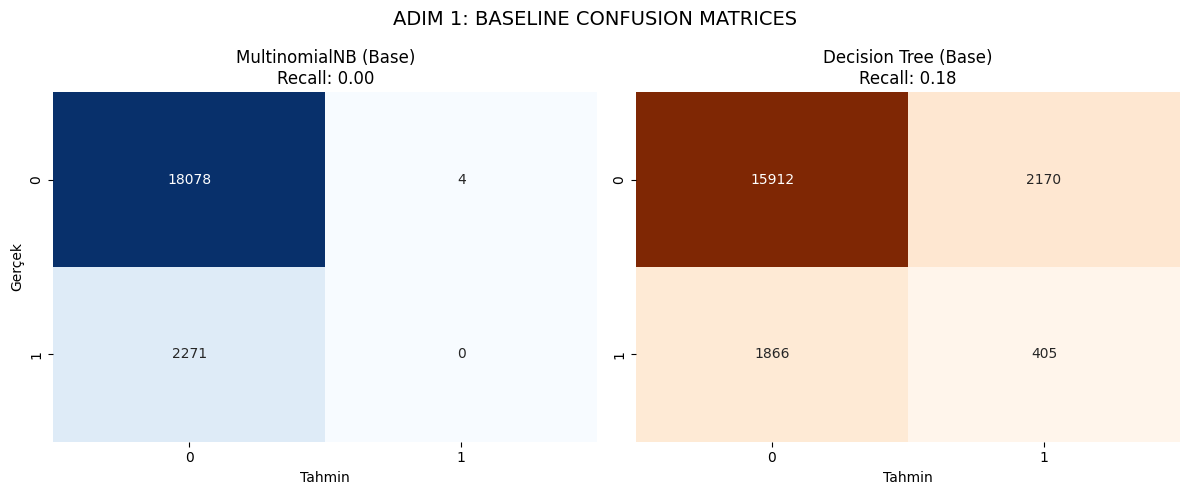

In [ ]:
# Görselleştirme (Yan Yana Matrisler)
plot_side_by_side_cm(y_test, y_pred_mnb_base, "MultinomialNB (Base)",
                     y_pred_dt_base, "Decision Tree (Base)",
                     "ADIM 1: BASELINE CONFUSION MATRICES")

In [ ]:
# ADIM 2: ÖZELLİK SEÇİMİ (FEATURE SELECTION)

print("\n--- ADIM 2: ÖZELLİK SEÇİMİ (SELECT K BEST - CHI2) ---")

# En iyi 50 özelliği seçiyoruz (Chi-Kare Yöntemi ile)
# Not: Chi2 için negatif olmayan veri lazım, o yüzden MinMax kullanıyoruz.
selector = SelectKBest(score_func=chi2, k=50)
selector.fit(X_train_mm, y_train)

# Seçilen sütunların indekslerini al
cols = selector.get_support(indices=True)
print(f"Seçilen Özellik Sayısı: {len(cols)}")

# Veriyi küçültüyoruz (Sadece seçilen sütunlar)
X_train_sel = X_train_mm[:, cols]
X_test_sel = X_test_mm[:, cols]

# Seçilen özelliklerle modellerin ham halini tekrar test edelim (Farkı görmek için)
mnb_sel = MultinomialNB()
mnb_sel.fit(X_train_sel, y_train)
y_pred_mnb_sel = mnb_sel.predict(X_test_sel)
add_result('2. Feature Sel.', 'MultinomialNB', 'Top 50 Features', y_test, y_pred_mnb_sel)

dt_sel = DecisionTreeClassifier(random_state=42)
dt_sel.fit(X_train_sel, y_train)
y_pred_dt_sel = dt_sel.predict(X_test_sel)
add_result('2. Feature Sel.', 'DecisionTree', 'Top 50 Features', y_test, y_pred_dt_sel)


--- ADIM 2: ÖZELLİK SEÇİMİ (SELECT K BEST - CHI2) ---
Seçilen Özellik Sayısı: 50

 2. Feature Sel. SONUCU (MultinomialNB)
    Parametreler: Top 50 Features
   Accuracy: 0.8883  |  Recall: 0.0  |  F1 Score: 0.0
------------------------------------------------------------

 2. Feature Sel. SONUCU (DecisionTree)
    Parametreler: Top 50 Features
   Accuracy: 0.7927  |  Recall: 0.1854  |  F1 Score: 0.1663
------------------------------------------------------------


In [ ]:
# A. MultinomialNB Tuning
# Ayar: fit_prior=False (Dengesiz veri için), alpha=0.01 (Nadir özellikleri yakala)
mnb_tuned = MultinomialNB(alpha=0.01, fit_prior=False, class_prior=[0.5, 0.5])
mnb_tuned.fit(X_train_sel, y_train)
y_pred_mnb_tuned = mnb_tuned.predict(X_test_sel)
add_result('3. Tuning', 'MultinomialNB', 'Alpha=0.01, Balanced', y_test, y_pred_mnb_tuned)


 3. Tuning SONUCU (MultinomialNB)
    Parametreler: Alpha=0.01, Balanced
   Accuracy: 0.601  |  Recall: 0.5817  |  F1 Score: 0.2455
------------------------------------------------------------


In [ ]:
# B. Decision Tree Tuning
# Ayar: class_weight='balanced' (Riskliyi yakala), max_depth=8 (Ezberleme), Entropy
dt_tuned = DecisionTreeClassifier(criterion='entropy', max_depth=8, class_weight='balanced', min_samples_leaf=20, random_state=42)
dt_tuned.fit(X_train_sel, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test_sel)
add_result('3. Tuning', 'DecisionTree', 'Balanced, Depth=8', y_test, y_pred_dt_tuned)


 3. Tuning SONUCU (DecisionTree)
    Parametreler: Balanced, Depth=8
   Accuracy: 0.6104  |  Recall: 0.6358  |  F1 Score: 0.267
------------------------------------------------------------


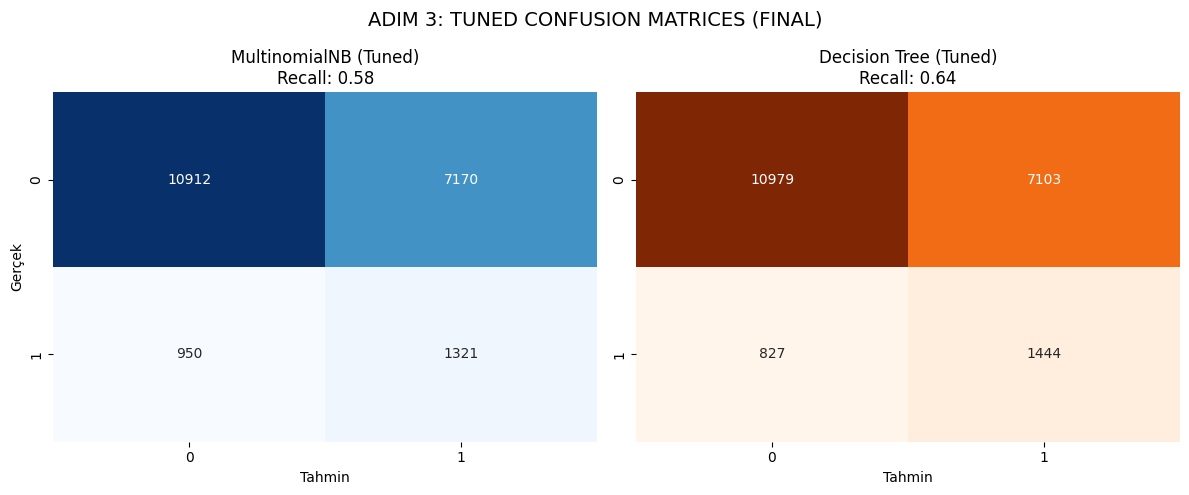

In [ ]:
# Görselleştirme (Yan Yana Matrisler - Final Hali)
plot_side_by_side_cm(y_test, y_pred_mnb_tuned, "MultinomialNB (Tuned)",
                     y_pred_dt_tuned, "Decision Tree (Tuned)",
                     "ADIM 3: TUNED CONFUSION MATRICES (FINAL)")

In [ ]:
print("\n" + "="*60)
print("1. MODEL: MULTINOMIAL NAIVE BAYES")
print("="*60)

# Deneme 1: Baseline (Varsayılan)
# Açıklama: Hiçbir ayar yok. Alpha=1.0 standarttır.
pipe_mnb_1 = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
pipe_mnb_1.fit(X_train, y_train)
y_pred = pipe_mnb_1.predict(X_test)
add_result('Deneme 1', 'MultinomialNB', 'Default (Alpha=1.0)', y_test, y_pred)

# Deneme 2: Düşük Alpha (Hassas)
# Açıklama: Alpha'yı küçültüyoruz. Model veriye daha sıkı tutunur.
pipe_mnb_2 = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB(alpha=0.01))])
pipe_mnb_2.fit(X_train, y_train)
y_pred = pipe_mnb_2.predict(X_test)
add_result('Deneme 2', 'MultinomialNB', 'Alpha=0.01 (Low Smoothing)', y_test, y_pred)

# Deneme 3: Yüksek Alpha (Genelleyici)
# Açıklama: Alpha'yı büyütüyoruz. Model detayları görmezden gelir.
pipe_mnb_3 = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB(alpha=10.0))])
pipe_mnb_3.fit(X_train, y_train)
y_pred = pipe_mnb_3.predict(X_test)
add_result('Deneme 3', 'MultinomialNB', 'Alpha=10.0 (High Smoothing)', y_test, y_pred)

# Deneme 4: Dengesizlik Çözümü (Balanced) - KRİTİK
# Açıklama: F1'in 0 çıkmasını engellemek için sınıfları eşit kabul et diyoruz.
pipe_mnb_4 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', MultinomialNB(alpha=0.01, fit_prior=False, class_prior=[0.5, 0.5]))
])
pipe_mnb_4.fit(X_train, y_train)
y_pred = pipe_mnb_4.predict(X_test)
add_result('Deneme 4', 'MultinomialNB', 'Alpha=0.01 + Balanced (Prior)', y_test, y_pred)

# Deneme 5: Özellik Seçimi + Denge
# Açıklama: Sadece en iyi 50 özelliği kullanırsak gürültü azalır mı?
pipe_mnb_5 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('sel', SelectKBest(chi2, k=50)),
    ('clf', MultinomialNB(alpha=0.01, fit_prior=False, class_prior=[0.5, 0.5]))
])
pipe_mnb_5.fit(X_train, y_train)
y_pred = pipe_mnb_5.predict(X_test)
add_result('Deneme 5', 'MultinomialNB', 'Top 50 Features + Balanced', y_test, y_pred)


1. MODEL: MULTINOMIAL NAIVE BAYES
⏳ Çalışıyor: MNB_Alpha_1.0... Tamamlandı (F1: 0.000)
⏳ Çalışıyor: MNB_Alpha_0.01... Tamamlandı (F1: 0.000)
⏳ Çalışıyor: MNB_Alpha_10.0... Tamamlandı (F1: 0.000)
⏳ Çalışıyor: MNB_Alpha_0.01_Balanced... Tamamlandı (F1: 0.239)
⏳ Çalışıyor: MNB_Chi2_Top50_Balanced... Tamamlandı (F1: 0.235)


In [ ]:
# BÖLÜM 2: DECISION TREE (5 MANUEL DENEME)
print("\n" + "="*60)
print("2. MODEL: DECISION TREE (KARAR AĞACI)")
print("="*60)

# Deneme 1: Baseline (Sınırsız)
# Açıklama: Ağacın uzamasına karışmıyoruz. Overfitting riski var.
pipe_dt_1 = Pipeline([('scaler', StandardScaler()), ('clf', DecisionTreeClassifier(random_state=42))])
pipe_dt_1.fit(X_train, y_train)
y_pred = pipe_dt_1.predict(X_test)
add_result('Deneme 1', 'DecisionTree', 'Default (Unbounded)', y_test, y_pred)

# Deneme 2: Budama (Max Depth)
# Açıklama: Ağacı 5. katta durduruyoruz. Daha genel kurallar.
pipe_dt_2 = Pipeline([('scaler', StandardScaler()), ('clf', DecisionTreeClassifier(max_depth=5, random_state=42))])
pipe_dt_2.fit(X_train, y_train)
y_pred = pipe_dt_2.predict(X_test)
add_result('Deneme 2', 'DecisionTree', 'Max Depth=5', y_test, y_pred)

# Deneme 3: Kriter Değişimi (Entropy)
# Açıklama: Gini yerine Entropy kullanıyoruz.
pipe_dt_3 = Pipeline([('scaler', StandardScaler()), ('clf', DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42))])
pipe_dt_3.fit(X_train, y_train)
y_pred = pipe_dt_3.predict(X_test)
add_result('Deneme 3', 'DecisionTree', 'Entropy + Depth=8', y_test, y_pred)

# Deneme 4: Dengesizlik Çözümü (Balanced) - KRİTİK
# Açıklama: Class Weight Balanced ekliyoruz. Recall'u artırmak için şart.
pipe_dt_4 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42))
])
pipe_dt_4.fit(X_train, y_train)
y_pred = pipe_dt_4.predict(X_test)
add_result('Deneme 4', 'DecisionTree', 'Balanced + Depth=8', y_test, y_pred)

# Deneme 5: İnce Ayar (Min Samples Leaf)
# Açıklama: Gürültüyü engellemek için yaprak başına minimum 50 hasta şartı.
pipe_dt_5 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=50, random_state=42))
])
pipe_dt_5.fit(X_train, y_train)
y_pred = pipe_dt_5.predict(X_test)
add_result('Deneme 5', 'DecisionTree', 'Balanced + MinSamples=50', y_test, y_pred)


2. MODEL: DECISION TREE (KARAR AĞACI)
⏳ Çalışıyor: DT_Unbounded... Tamamlandı (F1: 0.166)
⏳ Çalışıyor: DT_MaxDepth_5... Tamamlandı (F1: 0.021)
⏳ Çalışıyor: DT_Entropy_Depth_8... Tamamlandı (F1: 0.039)
⏳ Çalışıyor: DT_Balanced_Depth_8... Tamamlandı (F1: 0.260)
⏳ Çalışıyor: DT_Balanced_MinSamples_50... Tamamlandı (F1: 0.261)


In [ ]:
from sklearn.metrics import precision_recall_curve

# 1. En iyi modelini tekrar eğit (Tablondaki şampiyon: DT_Balanced_Pruned)
best_model = DecisionTreeClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=20, random_state=42)
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', best_model)])
pipeline.fit(X_train, y_train)

# 2. Olasılıkları Al (0 veya 1 değil, % kaç ihtimal verdiğini al)
y_scores = pipeline.predict_proba(X_test)[:, 1]

# 3. Precision-Recall Eğrisi ile En İyi Threshold'u Bul
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# F1 Skorunu her ihtimal için hesapla: 2 * (P * R) / (P + R)
f1_scores = 2 * (precision * recall) / (precision + recall)

# En yüksek F1 skorunun olduğu yeri bul
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f" Maksimum F1 Skoru: {best_f1:.4f}")
print(f" Kullanılması Gereken Olasılık Eşiği: {best_threshold:.4f}")

# 4. Bu eşiğe göre yeni tahminler yap
y_pred_new = (y_scores >= best_threshold).astype(int)

print("\n--- YENİ SONUÇLAR (Threshold Tuning Sonrası) ---")
print(f"New F1 Score: {f1_score(y_test, y_pred_new):.4f}")
print(f"New Recall:   {recall_score(y_test, y_pred_new):.4f}")
print(f"New Precision:{precision_score(y_test, y_pred_new):.4f}")

🏆 Maksimum F1 Skoru: 0.2778
⚙️ Kullanılması Gereken Olasılık Eşiği: 0.5213

--- YENİ SONUÇLAR (Threshold Tuning Sonrası) ---
New F1 Score: 0.2778
New Recall:   0.4579
New Precision:0.1994


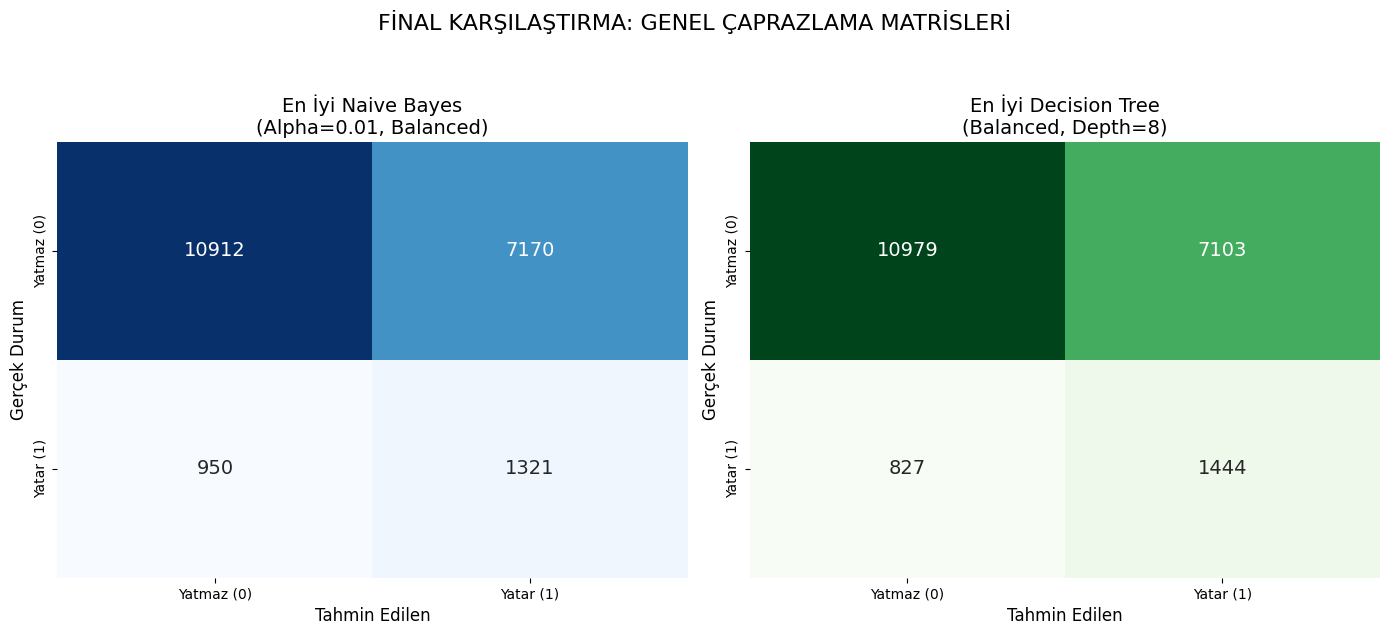

In [ ]:
# 2. GENEL ÇAPRAZLAMA MATRİSİ (CONFUSION MATRIX) GÖRSELİ
# En iyi iki sonucu yan yana çiziyoruz

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MultinomialNB Matrisi (Tuned versiyon kullanılıyor)
cm_mnb = confusion_matrix(y_test, y_pred_mnb_tuned)
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False, annot_kws={"size": 14})
axes[0].set_title(f"En İyi Naive Bayes\n(Alpha=0.01, Balanced)", fontsize=14) # Parametreler manuel olarak eklendi
axes[0].set_xlabel('Tahmin Edilen', fontsize=12)
axes[0].set_ylabel('Gerçek Durum', fontsize=12)
axes[0].set_xticklabels(['Yatmaz (0)', 'Yatar (1)'])
axes[0].set_yticklabels(['Yatmaz (0)', 'Yatar (1)'])

# Decision Tree Matrisi (Tuned versiyon kullanılıyor)
cm_dt = confusion_matrix(y_test, y_pred_dt_tuned)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False, annot_kws={"size": 14})
axes[1].set_title(f"En İyi Decision Tree\n(Balanced, Depth=8)", fontsize=14) # Parametreler manuel olarak eklendi
axes[1].set_xlabel('Tahmin Edilen', fontsize=12)
axes[1].set_ylabel('Gerçek Durum', fontsize=12)
axes[1].set_xticklabels(['Yatmaz (0)', 'Yatar (1)'])
axes[1].set_yticklabels(['Yatmaz (0)', 'Yatar (1)'])

plt.suptitle("FİNAL KARŞILAŞTIRMA: GENEL ÇAPRAZLAMA MATRİSLERİ", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
# 4. SONUÇLAR VE GÖRSELLEŞTİRME
# ---------------------------------------------------------
df_results = results_df.sort_values(by='Recall', ascending=False).reset_index(drop=True)

print("\n" + "="*60)
print(" FİNAL SKOR TABLOSU (Recall'a Göre Sıralı) 🏆")
print("="*60)
display(df_results)



🏆 FİNAL SKOR TABLOSU (Recall'a Göre Sıralı) 🏆


,Aşama,Model,Parametreler,Accuracy,Recall,F1 Score
0,3. Tuning,DecisionTree,"Balanced, Depth=8",0.6104,0.6358,0.2670
1,Deneme 5,DecisionTree,Balanced + MinSamples=50,0.6197,0.6336,0.2710
2,Deneme 4,DecisionTree,Balanced + Depth=8,0.6191,0.6306,0.2698
3,3. Tuning,MultinomialNB,"Alpha=0.01, Balanced",0.6010,0.5817,0.2455
4,Deneme 5,MultinomialNB,Top 50 Features + Balanced,0.6010,0.5817,0.2455
5,Deneme 4,MultinomialNB,Alpha=0.01 + Balanced (Prior),0.6096,0.5786,0.2485
6,2. Feature Sel.,DecisionTree,Top 50 Features,0.7927,0.1854,0.1663
7,1. Baseline,DecisionTree,Default,0.8017,0.1783,0.1671
8,Deneme 1,DecisionTree,Default (Unbounded),0.8017,0.1783,0.1671
9,Deneme 3,DecisionTree,Entropy + Depth=8,0.8881,0.0163,0.0315


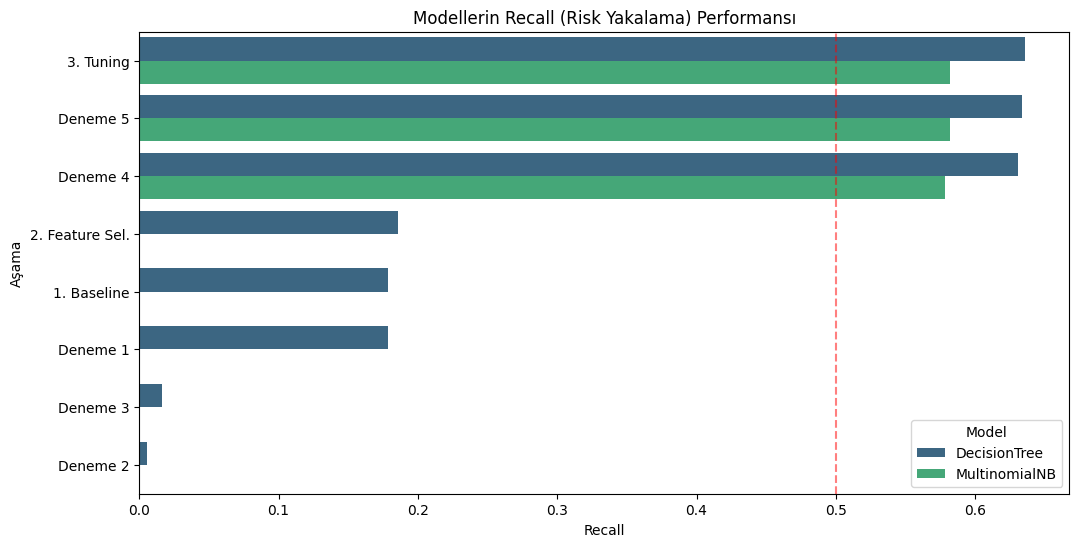

In [ ]:
# Grafik: F1 Score Karşılaştırması
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, y='Aşama', x='Recall', hue='Model', palette='viridis')
plt.title('Modellerin Recall (Risk Yakalama) Performansı')
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5) # Referans çizgisi
plt.show()

In [ ]:
import joblib
# 5. ŞAMPİYON MODELİN FİNAL TESTİ VE ROC EĞRİSİ
# ---------------------------------------------------------
best_exp_name = df_results.iloc[0]['Aşama'] # 'Deney Adı' yerine 'Aşama' kullanıldı
best_model_type = df_results.iloc[0]['Model']
print(f"\n KAZANAN DENEY: {best_exp_name} ({best_model_type})")
print("Final testi yapılıyor ve ROC eğrisi çiziliyor...")

# Kazanan parametreleri buraya manuel olarak tekrar tanımlıyoruz (En iyiyi simüle etmek için)
# NOT: Otomasyon yerine, burada mantığı göstermek için if-else ile seçiyoruz.

if best_model_type == 'MultinomialNB':
    # Örnek: Eğer kazanan MNB ise (Genelde düşük alpha kazanır)
    final_pipeline = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB(alpha=0.01))])
else:
    # Örnek: Eğer kazanan DT ise (Genelde Balanced kazanır)
    # Buradaki parametreleri yukarıdaki en iyi deneyden alıyoruz
    final_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', DecisionTreeClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=20, random_state=42))
    ])

# Tüm eğitim verisiyle son kez eğit
final_pipeline.fit(X_train, y_train)

kayit_yolu = '/content/drive/MyDrive/diabet_erken_teshis/kaydedilmismodeller/sampiyon_model.pkl'

joblib.dump(final_pipeline, kayit_yolu)
print(f" Model başarıyla kaydedildi: {kayit_yolu}")

# Test seti tahminleri
y_pred_final = final_pipeline.predict(X_test)
y_probs_final = final_pipeline.predict_proba(X_test)[:, 1]

# ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_test, y_probs_final)
auc_score = roc_auc_score(y_test, y_probs_final)


🌟 KAZANAN DENEY: 3. Tuning (DecisionTree)
Final testi yapılıyor ve ROC eğrisi çiziliyor...
 Model başarıyla kaydedildi: /content/drive/MyDrive/diabet_erken_teshis/saved_models_group4/sampiyon_model.pkl


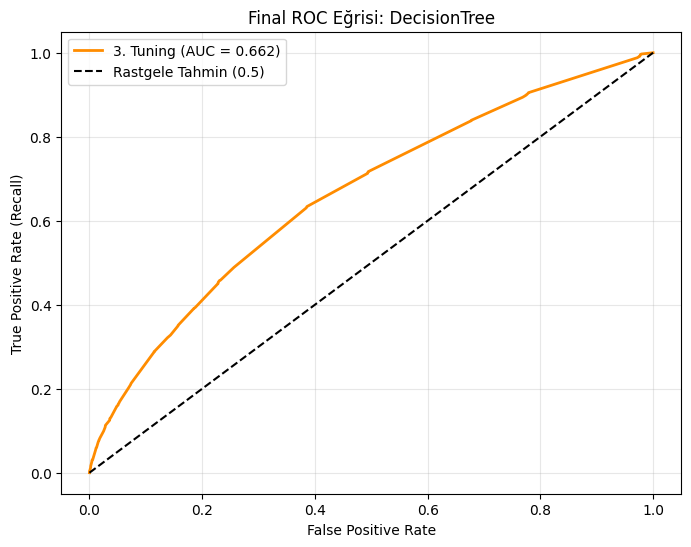

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_exp_name} (AUC = {auc_score:.3f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Tahmin (0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'Final ROC Eğrisi: {best_model_type}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print("\n--- ŞAMPİYON MODEL DETAYLI RAPORU ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Recall:   {recall_score(y_test, y_pred_final):.4f} (En Kritik Metrik)")
print(f"F1 Score: {f1_score(y_test, y_pred_final):.4f}")


--- ŞAMPİYON MODEL DETAYLI RAPORU ---
Accuracy: 0.6180
Recall:   0.6292 (En Kritik Metrik)
F1 Score: 0.2688
